# Overview: Application of Machine Learning Models to identify Phishing Activity
In this project, the goal is to identify the best approach using Machine Learning to detect Phishing Activity on the Ethereum Network. Significant focus of this project will be placed on data exploration, identifying key characteristics amongst the fraudulent activity, as well as identifying meaningful engineered features that may help to improve the accuracy of the subsequent Machine Learning Models.

Furthermore, throughout this project, I will be studying the Machine Learning Models utilised in depth instead of simply applying them in an attempt to identify what characteristics of the unique models lead them to outperform others in the context of this project.

# Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE


# Settings for Pandas dataframe display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# File Paths
transaction_file = '/Users/maverick/Data-Processing/Data/Raw Data Files/transaction_dataset.csv'
features_file = '/Users/maverick/Data-Processing/Data/Raw Data Files/eth_illicit_features.csv'

# Chapter 1 - Data Exploration

In this chapter, we will first be inspecting the individual dataframes to identify features that are relevant to this project and filtering out ones that are irrelevant. I retained only those columns that carry direct, interpretable information about an address's behavioural footprint on the chain and therefore have the highest empirical value for fraud modelling. Through this process, the retained features gives the model a rich yet manageable feature space while eliminating unnecessary or sparsely populated columns thereby reducing dimensionality, mitigates overfitting and speeds up downstream model training without sacrificing predictive signal.
<br>

# Chapter 1.1 - Inspecting Transactions Dataframe

In [16]:
transaction_df = pd.read_csv(transaction_file)
display(transaction_df)

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.000000,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.00,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.000000,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.00,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.050000,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.00,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.000000,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.00,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.000000,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.00,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,12.000000,2.821060,0.465461,12.200000,9.166365,0.0,0.0,0.0,17,36.665461,36.673777,0.0,0.008316,2.0,1.337000e+00,0.000000e+00,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,1.337000e+00,0.668500,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0.000000,0.000000,0.0,0.000000,1.0,1.337000e+01,0.000000e+00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13.37,1.337000e+01,13.370000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189

# Chapter 1.1.1 - Transaction Dataframe Analysis
In this section, we will be conducting an analysis of the transaction dataframe, helping to inform us on the empirical value of features to our goals and thus which to retain for model training. To achieve this, we will be looking at the characteristics of data that are labelled as fraudulent and identify if there is significant heterogeneity to the rest of the dataset.

In [17]:
filtered_transaction = transaction_df[transaction_df["FLAG"] == 1]

# Displaying the individual dataframes pre and post filtering for FLAG == 1
display(transaction_df.describe())
display(filtered_transaction.describe())

,Unnamed: 0,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9.841000e+03,9841.000000,9.841000e+03,9012.000000,9.012000e+03,9.012000e+03,9012.000000,9012.000000,9012.000000,9012.000000,9012.000000,9012.0,9012.0,9012.0,9012.0,9012.000000,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,4920.000000,1815.049893,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,523.152481,100.711721,4.800090,314.617297,44.755731,0.000003,0.000008,0.000005,283.362362,1.016092e+04,1.163832e+04,0.000008,1.477395e+03,36.255659,1.296207e+08,1.386849e+07,110.939207,5.638038,7.598535,0.003440,4.901909,0.0,0.0,0.0,0.0,485.614688,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,2840.996333,1222.621830,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,13008.821539,2885.002236,138.609682,6629.212643,239.080215,0.000225,0.000516,0.000323,1352.404013,3.583227e+05,3.642048e+05,0.000516,2.424254e+05,447.528908,1.053858e+10,1.180390e+09,6128.634953,105.252500,81.818470,0.065698,17.246576,0.0,0.0,0.0,0.0,16883.278712,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.560535e+07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,2460.000000,821.000000,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,1.000000,0.426905,0.000000,0.164577,0.086184,0.000000,0.000000,0.000000,4.000000,2.262059e-01,2.670424e+00,0.000000,6.214900e-04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,4920.000000,1641.000000,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,6.000000,1.729730,0.049126,4.999380,1.606000,0.000000,0.000000,0.000000,8.000000,1.248680e+01,3.052963e+01,0.000000,1.722000e-03,1.000000,1.000000e-12,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,7

,Unnamed: 0,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,2179.000000,2179.000000,2179.0,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.0,2179.0,2179.0,2179.000000,2179.000000,2179.000000,2179.0,2179.000000,1350.00000,1.350000e+03,1.350000e+03,1350.000000,1350.000000,1350.00000,1350.000000,1350.000000,1350.0,1350.0,1350.0,1350.0,1350.000000,1.350000e+03,1.350000e+03,1.350000e+03,1.350000e+03,1.350000e+03,1350.0,1350.0,1350.0,1350.000000,1350.000000
mean,8751.000000,1090.000000,1.0,3888.109780,2874.712639,55230.057953,5.173933,23.775585,0.093162,12.475906,3.290500,30.619509,53.383739,36.440837,6.522282,35.721383,16.263756,0.0,0.0,0.0,29.042680,87.373398,96.894721,0.0,9.521323,8.86000,1.727648e+07,8.349837e+07,308.238444,0.484444,4.18000,0.002963,4.140741,0.0,0.0,0.0,0.0,934.591286,1.698577e+07,8.366339e+06,7.540068e+04,8.341266e+07,4.160523e+07,0.0,0.0,0.0,1.533333,4.109630
std,629.167439,629.167439,0.0,17505.367743,10624.453455,107518.118553,21.884569,253.953161,0.356037,69.380810,11.746776,535.349338,707.310512,557.835910,110.740331,518.604992,270.486110,0.0,0.0,0.0,256.326956,1689.409333,1215.597248,0.0,1622.912647,38.25972,5.731590e+08,3.048258e+09,11322.083806,2.633982,13.54725,0.054373,12.809121,0.0,0.0,0.0,0.0,18220.463496,5.730895e+08,2.865383e+08,2.721789e+06,3.048256e+09,1.528143e+09,0.0,0.0,0.0,8.351258,12.696368
min,7662.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,-70019.914950,1.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,8206.500000,545.500000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.000000,1.00000,1.337000e+00,0.000000e+00,0.000000,0.000000,1.00000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,1.337000e+00,1.337000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
50%,8751.000000,1090.000000,1.0,0.000000,82.070000,7545.430000,1.000000,3.000000,0.000000,3.000000,1.000000,0.004463,0.997900,0.500134,0.010000,0.688005,0.499139,0.0,0.0,0.0,5.000000,0.999139,1.678836,0.0,0.000861,1.00000,1.337000e+01,0.000000e+00,0.000000,0.000000,1.00000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.337000,1.337000e+01,1.337000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,9295.500000,1634.500000,1.0,434.095000,694.700000,48303.700000,2.000000,11.000000,0.000000,9.000000,2.000000,0.150000,4.990015,1.082389,1.209350,6.589494,3.581926,0.0,0.0,0.0,16.000000,10.081873,13.113263,0.0,0.003444,2.00000,1.003370e+02,0.0

# Chapter 1.1.2 - Relevant Features in Transaction Dataframe
1. Avg min between sent tnx
2. Avg min between received tnx
3. Sent tnx
4. Received tnx
5. Number of Created Contracts
6. Unique Received From Addresses
7. Unique Sent to Addresses
8. min value received
9. max value received
10. avg value received
11. min value sent
12. max value sent
13. avg value sent
14. total transactions (including tnx to create contract)
15. total Ether sent
16. total ether received
17. total ether balance

# Chapter 1.2 - Inspecting Feature Dataframe

In [18]:
features_df = pd.read_csv(features_file)
display(features_df)

,address,flag,minTimeBetweenSentTnx,maxTimeBetweenSentTnx,avgTimeBetweenSentTnx,minTimeBetweenRecTnx,maxTimeBetweenRecTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqSentAddress,numUniqRecAddress,minValSent,maxValSent,avgValSent,minValReceived,maxValReceived,avgValReceived,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,activityDays,dailyMax,ratioRecSent,ratioSentTotal,ratioRecTotal,giniSent,giniRec,txFreq,stdBalanceEth
0,0xd0cc2b24980cbcca47ef755da88b220a82291407,1,0.0,2387389.0,5.807655e+04,89.0,1.501076e+09,7.148260e+07,46,66,21,0,47,17,0.000000,183.000000,5.559412,0.018779,266.000000,17.486340,87,366.921190,367.213130,0.0,0.291940,10,60,0.313433,0.750000,0.238636,0.969121,0.888782,1.891304,147.701484
1,0x4cdc1cba0aeb5539f2e0ba158281e67e0e54a9b1,1,0.0,0.0,0.000000e+00,3021091.0,1.502802e+09,7.529115e+08,35,0,2,0,0,2,0.000000,0.000000,0.000000,0.003541,0.010000,0.006771,2,0.000000,0.013541,0.0,0.013541,2,1,2.000000,0.000000,0.666667,0.000000,0.238480,0.057143,0.005000
2,0x00e01a648ff41346cdeb873182383333d2184dd1,1,37.0,25112882.0,1.710279e+06,0.0,1.500397e+09,6.820612e+07,299,15,22,0,13,21,0.000000,25.000000,13.330000,0.425099,49.999314,9.100750,37,199.950000,200.216494,0.0,0.266494,14,16,1.375000,0.394737,0.578947,0.465450,0.614205,0.123746,52.129575
3,0x858457daa7e087ad74cdeeceab8419079bc2ca03,1,0.0,642460.0,1.576106e+04,0.0,1.500037e+09,1.352571e+07,36,109,111,0,54,104,0.000000,680.000000,14.959358,0.010000,193.500000,14.689887,220,1630.570000,1630.577419,0.0,0.007419,36,67,1.009091,0.493213,0.502262,0.957906,0.794121,6.111111,233.689231
4,0x240e125c20a4cc84bd6e7f8d1fd07aff4c06d43d,1,0.0,0.0,0.000000e+00,3894.0,1.500402e+09,3.751409e+08,82,1,4,0,1,4,1.900000,1.900000,1.900000,0.002199,1.000000,0.475550,5,1.900000,1.902199,0.0,0.002199,3,3,2.000000,0.166667,0.666667,0.000000,0.406556,0.060976,0.757788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12141,0x38e404b6ca4549988ced1d065330f1f722787924,0,3.0,15139.0,1.186571e+03,698.0,1.656129e+09,1.275572e+08,25,14,13,0,5,3,0.000701,0.998845,0.221037,0.010000,1.000000,0.238751,27,3.094515,3.103762,0.0,0.009248,24,4,0.866667,0.500000,0.464286,0.643490,0.615051,1.080000,0.236468
12142,0x8f40dac94ac52f90218d9aa5e605fe39dabe3979,0,0.0,411419.0,2.206761e+04,0.0,1.648939e+09,8.295712e+07,149,119,20,0,21,3,0.000000,1.890758,0.136311,0.000000,1.901979,0.731046,139,16.220988,14.620924,0.0,-1.600064,136,3,0.166667,0.850000,0.142857,0.856372,0.289923,0.932886,0.617016
12143,0xb92027b6adee9f63290a5a1bd9d15d6a163f4012,0,0.0,0.0,0.000000e+00,0.0,4.086570e+05,7.712044e+03,48,0,528,1,0,487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,529,0.000000,0.000000,0.0,0.000000,41,296,528.000000,0.000000,0.996226,0.000000,0.000000,11.020833,0.000000
12144,0x0cd3724542af4be8243eba3f560c0c55c5abd1df,0,0.0,2003867.0,1.412816e+05,223.0,1.647548e+09,1.033063e+08,156,59,16,0,21,7,0.000000,0.620000,0.033431,0.000000,0.581600,0.100469,75,1.972436,1.607504,0.0,-0.364932,69,6,0.266667,0.776316,0.210526,0.907248,0.571522,0.480769,0.161996


# Chapter 1.2.1 - Features Dataframe Analysis
In this section, we will be conducting an analysis of the features dataframe, helping to inform us on the empirical value of features to our goals and thus which to retain for model training. To achieve this, we will be looking at the characteristics of data that are labelled as fraudulent and identify if there is significant heterogeneity to the rest of the dataset.

In [19]:
filtered_features = features_df[features_df["flag"] == 1]

display(features_df.describe())
display(filtered_features.describe())

,flag,minTimeBetweenSentTnx,maxTimeBetweenSentTnx,avgTimeBetweenSentTnx,minTimeBetweenRecTnx,maxTimeBetweenRecTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqSentAddress,numUniqRecAddress,minValSent,maxValSent,avgValSent,minValReceived,maxValReceived,avgValReceived,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,activityDays,dailyMax,ratioRecSent,ratioSentTotal,ratioRecTotal,giniSent,giniRec,txFreq,stdBalanceEth
count,12146.000000,1.214600e+04,1.214600e+04,1.214600e+04,1.214600e+04,1.214600e+04,1.214600e+04,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,1.214600e+04,1.214600e+04,12146.000000,1.214600e+04,12146.000000,12146.000000,12146.000000,12146.000000,12146.000000,1.214600e+04,1.214600e+04,12146.000000,1.214600e+04
mean,0.424008,2.649065e+04,4.270947e+07,3.648564e+06,2.499426e+05,1.162226e+09,1.601823e+08,191.749630,517.366787,678.387617,1.760333,99.648938,278.234398,6.254205,166.900458,12.146658,13.719381,265.202176,52.052336,1197.514737,3.060886e+03,2.924125e+03,0.003690,-1.367650e+02,85.492343,209.392393,581.427949,0.458685,0.452111,4.341055e-01,4.104000e-01,64.605495,6.970988e+02
std,0.494212,7.167752e+05,2.510061e+08,4.121296e+07,3.403948e+06,7.159138e+08,2.329373e+08,299.970482,1875.017481,2253.808922,105.556010,622.977995,1124.944769,247.789066,6049.068917,296.204395,494.780188,8203.540956,2668.284325,2935.498052,9.265957e+04,5.823186e+04,0.354197,6.582241e+04,172.709068,974.655740,2206.404201,0.332333,0.317690,3.745526e-01,3.009740e-01,543.602564,2.432648e+04
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,-5.348493e+06,1.000000,1.000000,0.000000,0.000000,0.000000,-6.735319e-17,-9.316840e-17,0.001145,0.000000e+00
25%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.794640e+06,8.564709e+04,9.000000,1.000000,3.000000,0.000000,1.000000,2.000000,0.000000,0.021382,0.004042,0.000000,0.119870,0.041957,7.000000,3.350184e-02,3.053866e-01,0.000000,-3.532467e-01,3.000000,2.000000,0.230311,0.142857,0.186526,0.000000e+00,9.707937e-02,0.277778,8.364961e-02
50%,0.000000,0.000000e+00,2.042395e+05,1.490919e+04,4.800000e+01,1.578994e+09,4.776982e+07,68.000000,6.000000,11.000000,0.000000,3.000000,5.000000,0.000000,1.006568,0.137807,0.006396,1.000000,0.250000,34.000000,3.000000e+00,3.796921e+00,0.000000,1.563244e-03,15.000000,5.000000,0.620312,0.454545,0.375000,4.940496e-01,4.459279e-01,1.080336,9.335405e-01
75%,1.000000,8.000000e+01,1.845179e+06,1.391289e+05,7.147500e+02,1.640623e+09,2.192212e+08,251.000000,70.000000,55.000000,0.000000,17.000000,16.000000,0.052306,7.028250,1.302288,0.057475,5.000000,1.042968,282.000000,2.380862e+01,2.332307e+01,0.000000,4.064367e-02,85.000000,24.000000,2.741071,0.773654,0.714286,8.008659e-01,6.347963e-01,4.000000,6.826739e+00
max,1.000000,6.198813e+07,1.658260e+09,8.291299e+08,1.508562e+08,1.658260e+09,8.309932e+08,2293.000000,10000.000000,10000.000000,9947.000000,9950.000000,9996.000000,25533.614329,611102.014456,25533.614329,25533.614518,800000.000000,283618.831593,19948.000000,6.813193e+06,2.955140e+06,39.000000,1.847901e+06,1912.000000,10000.000000,10000.000000,0.999900,0.999900,9.998963e-01,9.998940e-01,10000.000000,2.038484e+06


,flag,minTimeBetweenSentTnx,maxTimeBetweenSentTnx,avgTimeBetweenSentTnx,minTimeBetweenRecTnx,maxTimeBetweenRecTnx,avgTimeBetweenRecTnx,lifetime,sentTransactions,receivedTransactions,createdContracts,numUniqSentAddress,numUniqRecAddress,minValSent,maxValSent,avgValSent,minValReceived,maxValReceived,avgValReceived,totalTransactions,totalEtherSent,totalEtherReceived,totalEtherSentContracts,totalEtherBalance,activityDays,dailyMax,ratioRecSent,ratioSentTotal,ratioRecTotal,giniSent,giniRec,txFreq,stdBalanceEth
count,5150.0,5.150000e+03,5.150000e+03,5.150000e+03,5.150000e+03,5.150000e+03,5.150000e+03,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5.150000e+03,5.150000e+03,5150.000000,5150.000000
mean,1.0,3.670474e+04,2.703673e+07,3.403620e+06,2.526261e+05,1.169306e+09,1.913779e+08,131.382718,23.899029,45.413592,0.181553,9.524078,29.732427,14.632849,75.033765,26.056919,19.215942,66.104417,31.162584,69.494175,145.791257,116.400965,0.000347,-29.390639,17.719612,21.285631,16.632620,0.326054,0.544461,3.476250e-01,3.777511e-01,4.043529,42.998235
std,0.0,6.072478e+05,1.912071e+08,3.466067e+07,4.245601e+06,6.796368e+08,2.411277e+08,275.463577,177.591921,285.665106,1.193402,51.106970,185.648357,380.387342,884.482929,453.277959,545.460696,822.225329,578.402981,351.351887,1563.392073,1160.126076,0.009153,1158.407970,53.400110,124.929646,217.268827,0.257353,0.266114,3.570054e-01,2.829090e-01,21.424506,529.719354
min,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-70019.779900,1.000000,1.000000,0.000000,0.000000,0.000000,-1.750068e-17,-3.155304e-17,0.001145,0.000000
25%,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.825453e+07,2.387077e+06,3.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.500000,0.171207,0.000350,0.494232,0.144832,5.000000,0.791291,0.968637,0.000000,0.000057,2.000000,2.000000,0.500000,0.111111,0.333333,0.000000e+00,4.404237e-02,0.200000,0.318671
50%,1.0,0.000000e+00,4.237600e+04,8.455729e+03,8.600000e+01,1.528357e+09,8.464054e+07,20.000000,2.000000,7.000000,0.000000,2.000000,5.000000,0.030338,3.506269,1.271346,0.015000,1.990000,0.666670,12.000000,5.494113,5.227351,0.000000,0.001404,4.000000,4.000000,1.111111,0.300000,0.520000,2.909062e-01,4.109902e-01,0.933333,1.607918
75%,1.0,2.090000e+02,1.169130e+06,1.759735e+05,9.695000e+02,1.587396e+09,3.035401e+08,115.000000,10.000000,21.000000,0.000000,6.000000,16.000000,1.894332,15.000000,6.001526,0.249895,7.500000,1.850370,37.000000,26.058408,23.994615,0.000000,0.010000,13.000000,13.000000,3.744318,0.500000,0.777778,6.660904e-01,5.970488e-01,2.800000,6.906014
max,1.0,3.351578e+07,1.657572e+09,8.275693e+08,1.508562e+08,1.658099e+09,8.290650e+08,1938.000000,9010.000000,9999.000000,42.000000,3183.000000,9581.000000,25533.614329,25533.614518,25533.614329,25533.614518,25533.614518,25533.614518,10000.000000,70020.000000,43479.469002,0.506304,12991.469002,1263.000000,4804.000000,9999.000000,0.994318,0.999800,9.983627e-01,9.996676e-01,909.090909,25488.516897


# Chapter 1.2.2 - Relevant Features in Features Dataframe
1. minTimeBetweenSentTnx
2. MaxTimeBetweenSentTnx
3. avgTimeBetweenSentTnx
4. mineTimeBetweenRecTnx
5. MaxTimeBetweenRecTnx
6. avgTimeBetweenRecTnx
7. sentTransactions
8. receivedTransactions
9. createdContracts
10. numUniqSentAddress
11. numUniqRecAddress
12. minValSent
14. maxValSent
15. avgValSent
16. minValSent
17. maxValSent
18. avgValSent
19. totalTransactions
20. totalEtherSent
21. totalEtherReceived
22. totalEtherBalance
23. activityDays
24. dailyMax
25. ratioRecSent
26. ratioSentTotal
27. ratioRecTotal
28. txFreq

# Chapter 1.3 - List of Retained Columns and Feature Mapping
After inspecting the individual dataframes, the following features are kept, mapped to interpretable feature names, and merged into a single dataframe.

The following criterias were considered when choosing features to retain for the merged dataframe:
1. The feature is present in both individual dataframes
2. The feature displays significant heterogeneity and/or is deemed logically relevant to the research question

Format is as follows: <br>
[New Feature Name]: (Feature Name in Transaction Dataframe), (Feature Name in Features Dataframe)

List of retained features: <br>
1. fraud_label: FLAG, flag
2. transaction_frequency_sent: Avg min between sent tnx, minTimeBetweenSentTnx
3. transaction_frequency_received: Avg min between received tnx, avgTimeBetweenRecTnx
4. contracts_created: Number of Created Contracts, createdContracts
5. unique_contacts_sent: Unique Sent To Addresses, numUniqSentAddress
6. unique_contacts_received': Unique Received From Addresses, numUniqRecAddress
7. avg_value_sent: avg val sent, avgValSent
8. avg_value_received: avg val received, avgValRec
9. transaction_count: total transactions, totalTransactions
10. total_ether_sent: total Ether sent, totalEtherSent
11. total_ether_received: total ether received, totalEtherReceived
12. account_balance: total ether balance, totalEtherBalance

<b>Reasons for Exclusion: </b><br>
sentTnx, recTnx: removed as transaction_frequency captures sufficient information <br>
minValSent, maxValSent, minValRec, maxValRec: min values display little heterogeneity, overall information captures by averages <br>
The rest: Feature was not present in both dataframes

In [ ]:
feature_mappings = {
    # Core fraud detection features
    'fraud_label': ['FLAG', 'flag'],
    'transaction_count': ['total transactions (including tnx to create contract', 'totalTransactions'],
    'account_balance': ['total ether balance', 'totalEtherBalance'],
    
    # Transaction patterns
    'transaction_frequency_sent': ['Avg min between sent tnx', 'avgTimeBetweenSentTnx'],
    'transaction_frequency_received': ['Avg min between received tnx', 'avgTimeBetweenRecTnx'],
    'unique_contacts_sent': ['Unique Sent To Addresses', 'numUniqSentAddress'],
    'unique_contacts_received': ['Unique Received From Addresses', 'numUniqRecAddress'],
    
    # Transaction values
    'avg_value_sent': ['avg val sent', 'avgValSent'],
    'avg_value_received': ['avg val received', 'avgValReceived'],
    
    # Activity metrics
    'total_ether_sent': ['total Ether sent', 'totalEtherSent'],
    'total_ether_received': ['total ether received', 'totalEtherReceived'],
    'contract_creation': ['Number of Created Contracts', 'createdContracts']
}

# Create standardized dataframes
transaction_standardized = pd.DataFrame()
features_standardized = pd.DataFrame()

# Map features with new standardized names
for new_col, [transaction_col, features_col] in feature_mappings.items():
    if transaction_col in transaction_df.columns and features_col in features_df.columns:
        transaction_standardized[new_col] = transaction_df[transaction_col]
        features_standardized[new_col] = features_df[features_col]


print("Dataset shapes before merging:")
print(f"Transaction dataset: {transaction_standardized.shape}")
print(f"Features dataset: {features_standardized.shape}")

# Merge datasets
merged_df = pd.concat([transaction_standardized, features_standardized], axis=0, ignore_index=True)

print("\nDataset shapes after merging:")
print(f"Merged dataset: {merged_df.shape}")

# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Save the final dataset
merged_df.to_csv('/Users/maverick/Data-Processing/Data/Merged Data/merged_dataset.csv', index=False)
print("\nSaved standardized dataset to 'Data/Merged Data/merged_dataset.csv'")

Dataset shapes before merging:
Transaction dataset: (9841, 12)
Features dataset: (12146, 12)

Dataset shapes after merging:
Merged dataset: (21987, 12)

Number of duplicate rows: 1580

Saved standardized dataset to 'Data/Merged Data/merged_dataset.csv'

Saved standardized dataset to 'Data/Merged Data/merged_dataset.csv'


<b>Note: Duplicate rows are not removed as the "duplication is caused via removal of the other features 

# Chapter 2 - Data Preprocessing

In this step, we will be pre-processing the data to appropriately fill in any null values and handle outliers appropriately.

# Chapter 2.1 - Handling Null Values

In [21]:
merged = pd.read_csv("/Users/maverick/Data-Processing/Data/Merged Data/merged_dataset.csv")

# Checking for Null Values
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21987 entries, 0 to 21986
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fraud_label                     21987 non-null  int64  
 1   transaction_count               21987 non-null  int64  
 2   account_balance                 21987 non-null  float64
 3   transaction_frequency_sent      21987 non-null  float64
 4   transaction_frequency_received  21987 non-null  float64
 5   unique_contacts_sent            21987 non-null  int64  
 6   unique_contacts_received        21987 non-null  int64  
 7   avg_value_sent                  21987 non-null  float64
 8   avg_value_received              21987 non-null  float64
 9   total_ether_sent                21987 non-null  float64
 10  total_ether_received            21987 non-null  float64
 11  contract_creation               21987 non-null  int64  
dtypes: float64(7), int64(5)
memory u

<b> There are no null values present in the dataset, thus no need for imputation </b>

# Chapter 2.2 - Outliers Management
In this segment, we will handle outliers through winsorization at the 5th and 95th percentiles.

In [22]:
def winsorize(df, cols, lower_quantile = 0.10, upper_quantile = 0.90):
    df_winsorized = df.copy()
    for col in cols:
        if col not in df_winsorized.columns:
            raise ValueError(f"Columns {col} not found in Dataframe")

        lower_bound = df_winsorized[col].quantile(lower_quantile)
        upper_bound = df_winsorized[col].quantile(upper_quantile)
        df_winsorized[col] = df_winsorized[col].clip(lower = lower_bound, upper = upper_bound)

    return df_winsorized

# Winsorize all columns except fraud label which is a binary column
cols_to_winsorize = list(merged_df.columns)
cols_to_winsorize.remove('fraud_label')

winsorized_df = winsorize(merged_df, cols_to_winsorize)
winsorized_df.to_csv("/Users/maverick/Data-Processing/Data/Cleaned Data/cleaned_data.csv")
display(winsorized_df.describe())

,fraud_label,transaction_count,account_balance,transaction_frequency_sent,transaction_frequency_received,unique_contacts_sent,unique_contacts_received,avg_value_sent,avg_value_received,total_ether_sent,total_ether_received,contract_creation
count,21987.000000,21987.000000,21987.000000,21987.000000,2.198700e+04,21987.000000,21987.000000,21987.000000,21987.000000,21987.000000,21987.000000,21987.00000
mean,0.333333,199.894656,0.372513,44530.907151,6.169157e+07,8.969664,8.766316,6.053756,7.624315,51.278601,60.474551,0.13890
std,0.471415,385.346165,4.438249,85683.897649,1.101308e+08,14.636750,11.614630,11.171438,15.923481,87.525313,100.737079,0.34585
min,0.000000,2.000000,-7.434723,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.003222,0.000000,0.011052,0.00000
25%,0.000000,4.000000,0.000000,0.000000,1.020000e+00,1.000000,1.000000,0.008546,0.099454,0.073127,0.811135,0.00000
50%,0.000000,18.000000,0.001638,217.160000,1.033698e+04,2.000000,3.000000,0.440000,0.624387,5.167382,8.870386,0.00000
75%,1.000000,133.000000,0.042014,32698.728028,6.604927e+07,8.000000,10.000000,4.512919,3.322822,62.225404,77.989072,0.00000
max,1.000000,1235.200000,11.245396,265984.989744,3.296848e+08,46.000000,38.000000,33.666149,50.500000,277.495840,320.790862,1.00000


# Chapter 2.3 - Engineering Features
In this segment, we will be engineering features that aim to provide empirical value to the research question and help increase accuracy of the models trained.

In [23]:
eps = 1e-5  # small constant to avoid division by zero or log(0)
df = winsorized_df.copy()

# 1. Flags wallets in the top 5% of account_balance
threshold = df["account_balance"].quantile(0.95)
df["is_high_balance"] = (df["account_balance"] > threshold).astype(int)

# 2. Flags wallet that sends/receives very frequently (<2 min between transactions)
df["high_txn_freq_flag"] = (
    (df["transaction_frequency_sent"] < 2) |
    (df["transaction_frequency_received"] < 2)
).astype(int)

# 3. Net flow of ETH (+ means net inflow of ETH, - means draining behaviour)
df["net_flow"] = df["total_ether_received"] - df["total_ether_sent"]

# 4. Spread in transactions (volatility)
df["spread_received"] = df["avg_value_received"] - df["avg_value_received"]

# 5. Contract activity flag
df["contract_activity_flag"] = (
    (df["contract_creation"] > 0)
).astype(int)

# 6. Log transformations for skewed data
df["log_balance"] = np.log1p(df["account_balance"].clip(lower=0))
df["log_txn_count"] = np.log1p(
    df["transaction_frequency_sent"] + df["transaction_frequency_received"]
)

df.to_csv("/Users/maverick/Data-Processing/Data/Engineered Data/engineered_data.csv")
display(df.describe())

,fraud_label,transaction_count,account_balance,transaction_frequency_sent,transaction_frequency_received,unique_contacts_sent,unique_contacts_received,avg_value_sent,avg_value_received,total_ether_sent,total_ether_received,contract_creation,is_high_balance,high_txn_freq_flag,net_flow,spread_received,contract_activity_flag,log_balance,log_txn_count
count,21987.000000,21987.000000,21987.000000,21987.000000,2.198700e+04,21987.000000,21987.000000,21987.000000,21987.000000,21987.000000,21987.000000,21987.00000,21987.0,21987.000000,21987.000000,21987.0,21987.00000,21987.000000,21987.000000
mean,0.333333,199.894656,0.372513,44530.907151,6.169157e+07,8.969664,8.766316,6.053756,7.624315,51.278601,60.474551,0.13890,0.0,0.467822,9.195950,0.0,0.13890,0.331866,11.023535
std,0.471415,385.346165,4.438249,85683.897649,1.101308e+08,14.636750,11.614630,11.171438,15.923481,87.525313,100.737079,0.34585,0.0,0.498975,59.163439,0.0,0.34585,0.786048,6.724967
min,0.000000,2.000000,-7.434723,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.003222,0.000000,0.011052,0.00000,0.0,0.000000,-277.484788,0.0,0.00000,0.000000,0.000000
25%,0.000000,4.000000,0.000000,0.000000,1.020000e+00,1.000000,1.000000,0.008546,0.099454,0.073127,0.811135,0.00000,0.0,0.000000,0.000786,0.0,0.00000,0.000000,5.591223
50%,0.000000,18.000000,0.001638,217.160000,1.033698e+04,2.000000,3.000000,0.440000,0.624387,5.167382,8.870386,0.00000,0.0,0.000000,0.005990,0.0,0.00000,0.001637,10.288230
75%,1.000000,133.000000,0.042014,32698.728028,6.604927e+07,8.000000,10.000000,4.512919,3.322822,62.225404,77.989072,0.00000,0.0,1.000000,0.167219,0.0,0.00000,0.041155,18.006453
max,1.000000,1235.200000,11.245396,265984.989744,3.296848e+08,46.000000,38.000000,33.666149,50.500000,277.495840,320.790862,1.00000,0.0,1.000000,320.790862,0.0,1.00000,2.505150,19.614454


# Chapter 3 - Data Validation
In this segment, we will now examine the dataframe after the data preprocessing steps to ensure that all variables are in order pre-training.

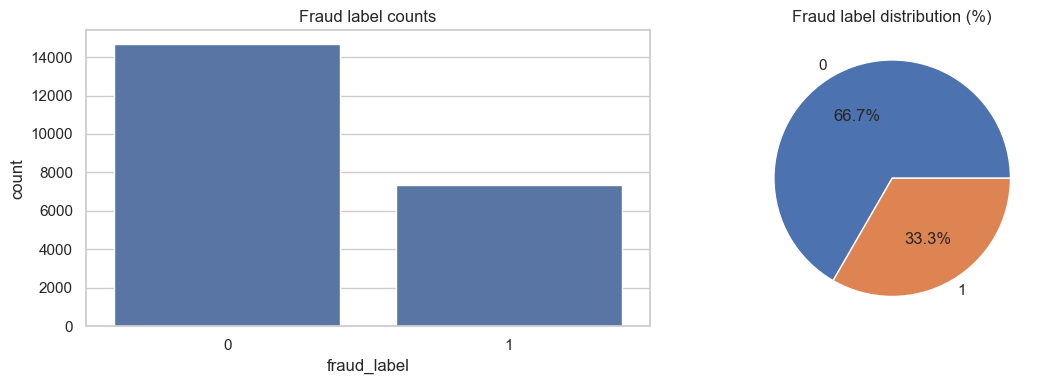

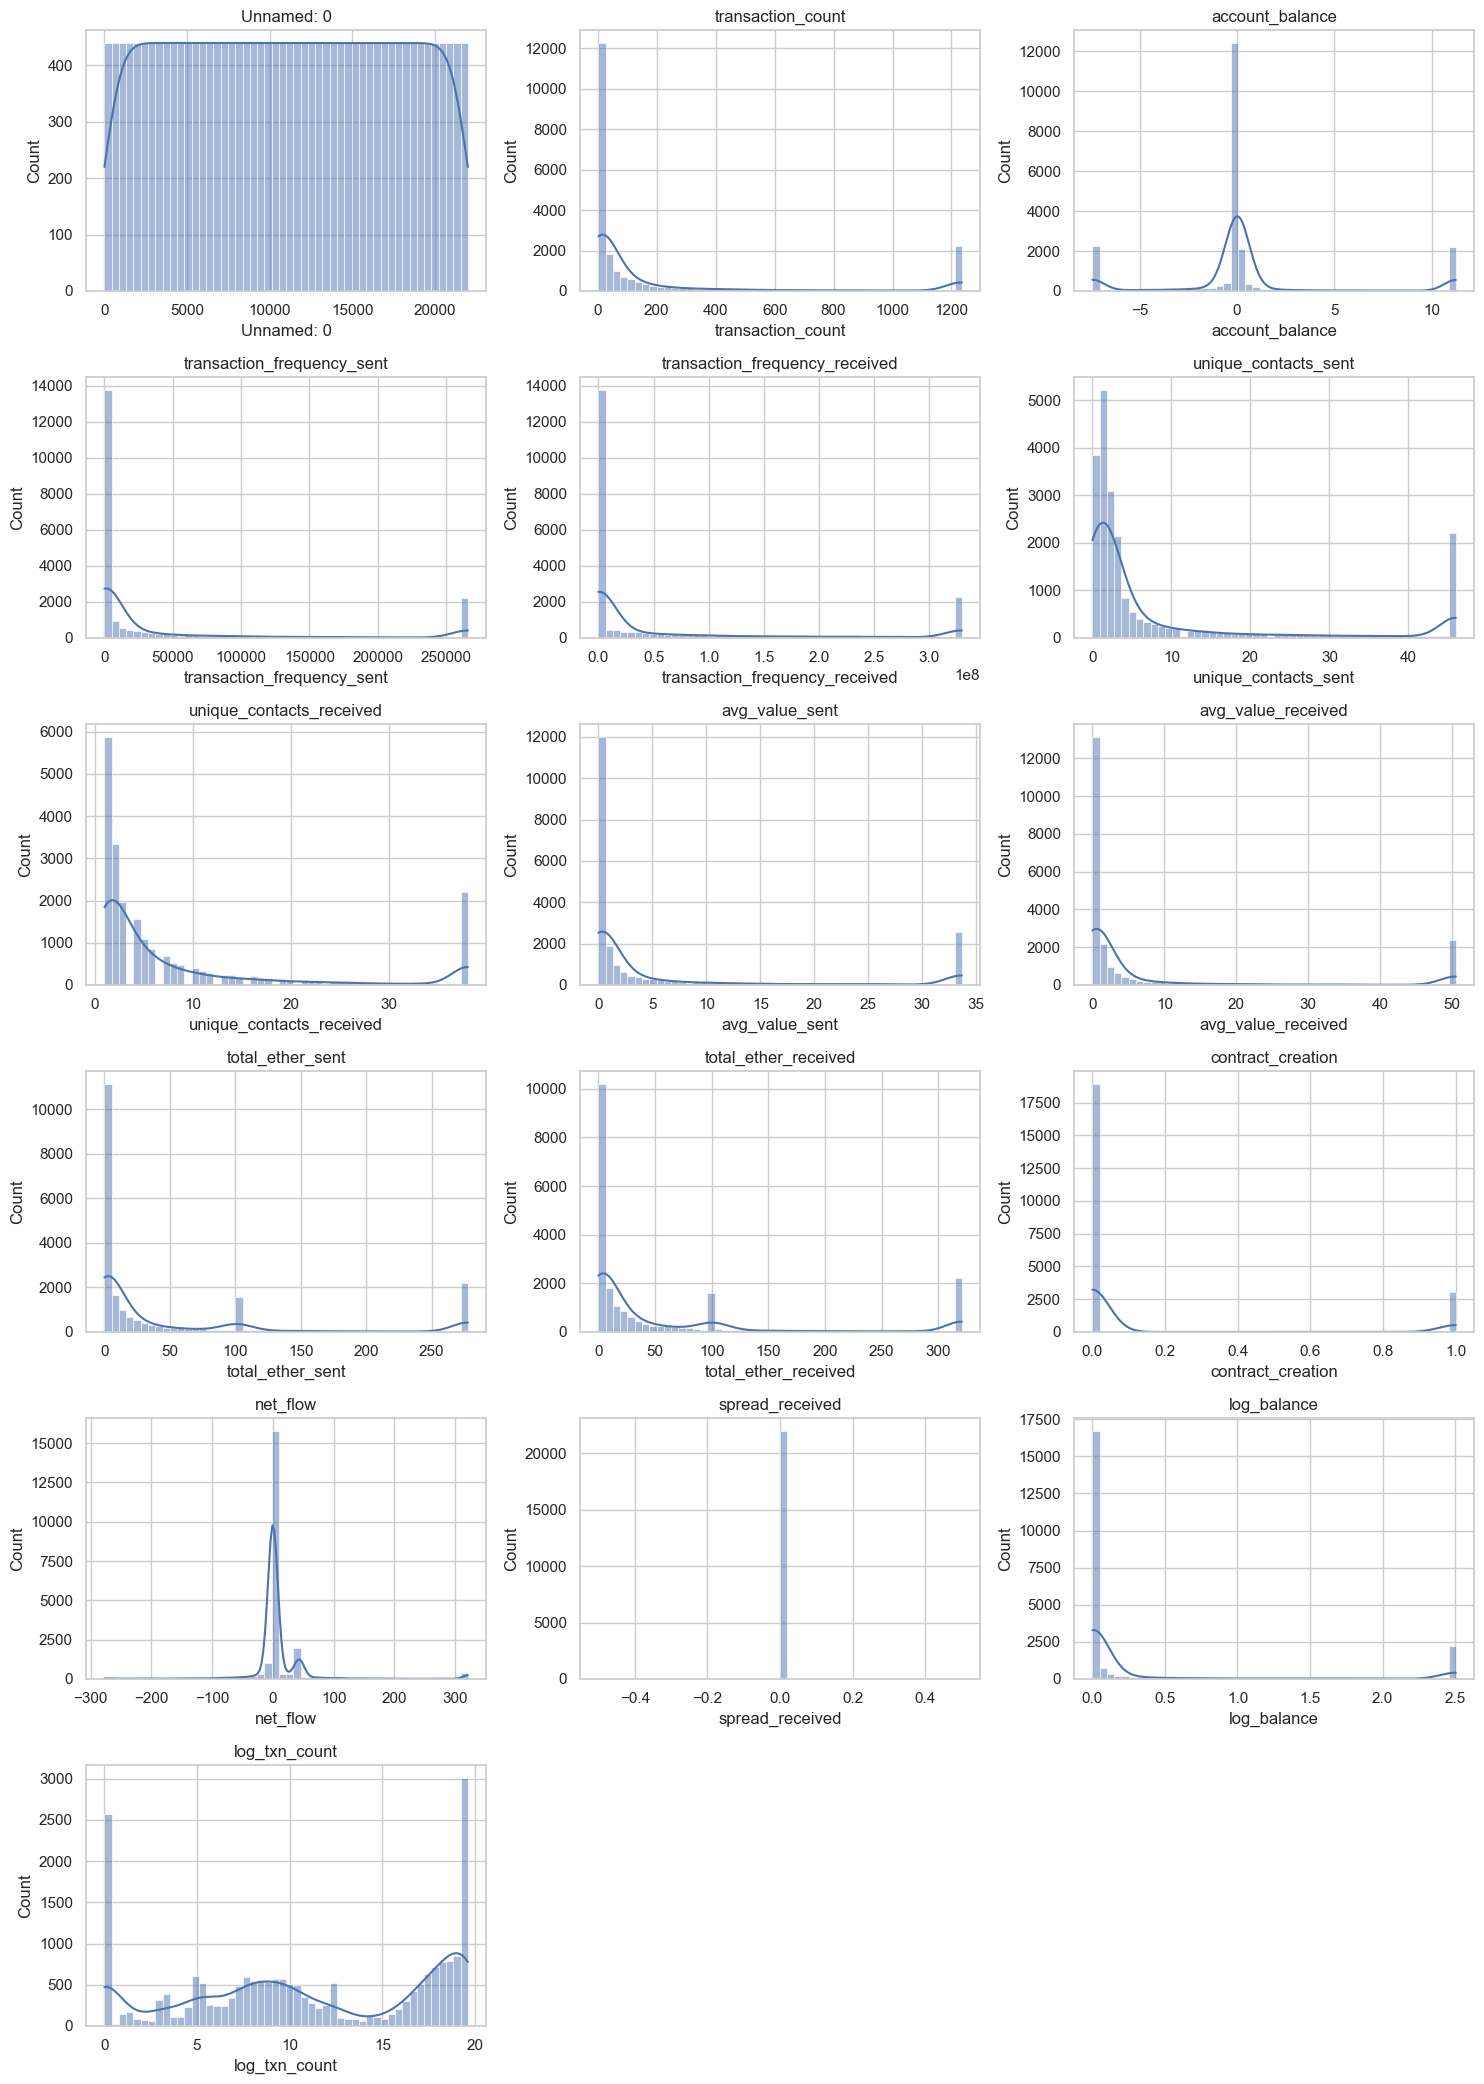

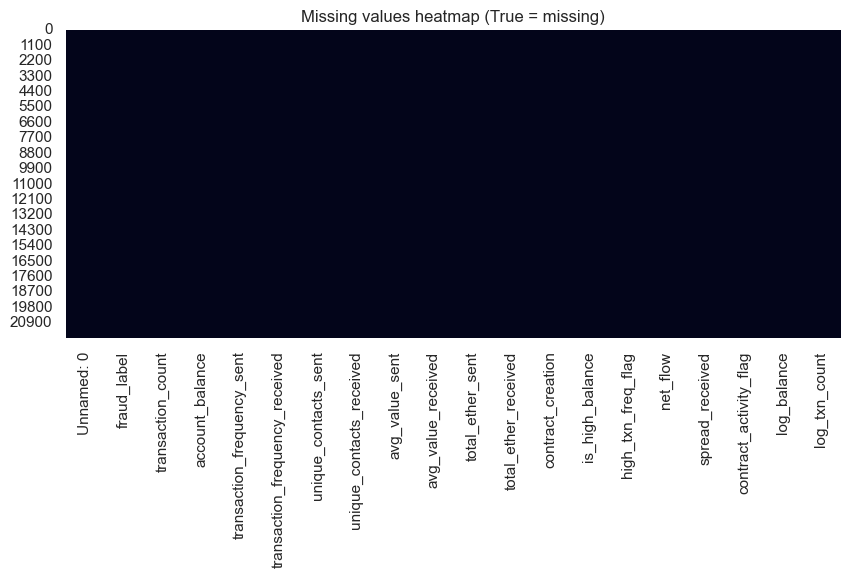

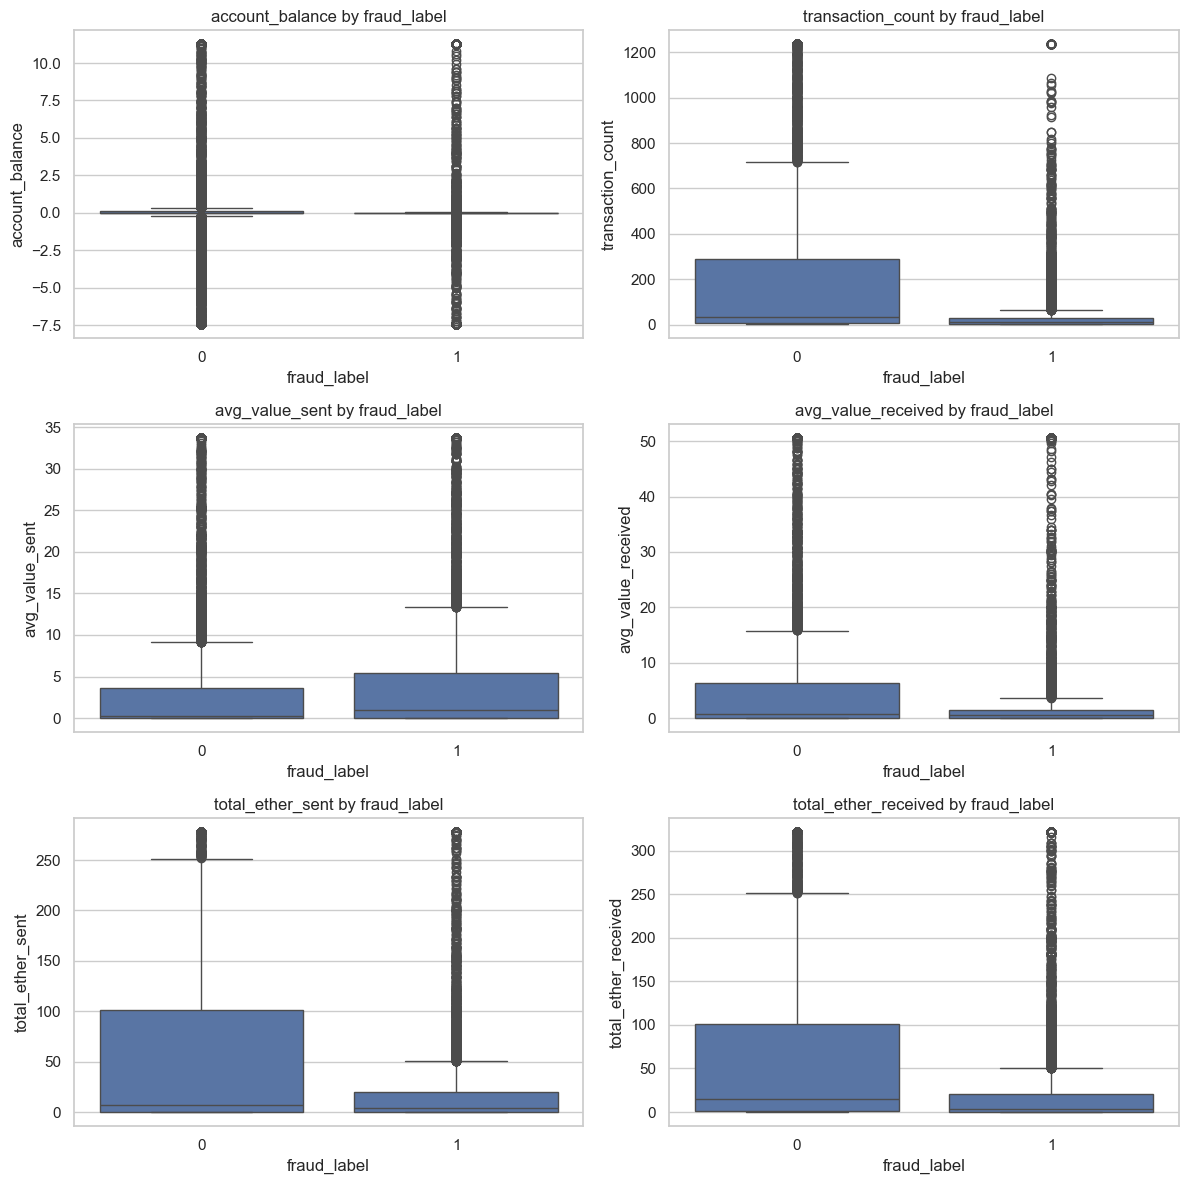

Data validation plots complete


In [26]:
# Load engineered data (produced in preprocessing)
engineered_path = Path('/Users/maverick/Data-Processing/Data/Engineered Data/engineered_data.csv')

df = pd.read_csv(engineered_path)

# Set plotting style
sns.set(style='whitegrid', context='notebook')
%matplotlib inline

# 1) Class balance
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='fraud_label', data=df, ax=ax[0])
ax[0].set_title('Fraud label counts')
ax[0].set_xlabel('fraud_label')
ax[0].set_ylabel('count')
# percentage pie
df['fraud_label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], ylabel='')
ax[1].set_title('Fraud label distribution (%)')
plt.tight_layout()
plt.show()

# 2) Numeric distributions - histograms and KDEs for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove binary/flag columns from distributions where appropriate
numeric_plot_cols = [c for c in numeric_cols if c not in ['fraud_label', 'is_high_balance', 'high_txn_freq_flag', 'contract_activity_flag']]
n = len(numeric_plot_cols)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3.5))
axes = axes.flatten() if n > 1 else [axes]
for i, col in enumerate(numeric_plot_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=50)
    axes[i].set_title(col)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# 3) Missingness overview
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing values heatmap (True = missing)')
plt.show()

# 4) Boxplots for key features by fraud label to inspect distribution and outliers
key_features = ['account_balance', 'transaction_count', 'avg_value_sent', 'avg_value_received', 'total_ether_sent', 'total_ether_received']
existing_key_features = [c for c in key_features if c in df.columns]
m = len(existing_key_features)
cols = 2
rows = int(np.ceil(m / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten() if m > 1 else [axes]
for i, col in enumerate(existing_key_features):
    sns.boxplot(x='fraud_label', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by fraud_label')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

print('Data validation plots complete')

# Chapter 4 - Machine Learning Models

# Chapter 5 - Interpretation of Results